In [ ]:
import time
import random
import pickle
import keras
import imblearn
import numpy as np
import pandas as pd
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.kernel_approximation import Nystroem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data604_final_project/dataset.csv')
df.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [ ]:
# drop columns like encounter_id and patient_id since they are not numerical or categorical
df = df.drop(['encounter_id','patient_id','hospital_id','icu_id','Unnamed: 83'],axis=1)
# drop rows with NULL values
df.dropna(inplace=True)
# replace strings with categories in numbers, replace null values and other/unknown with a 0
df['ethnicity'].replace(['Caucasian', 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'],[1,2,3,4,5,0], inplace=True)
df['gender'].replace(['M', 'F'],[1,2], inplace=True)
df['icu_admit_source'].replace(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU'],[1,2,3,4,5], inplace=True)
df['icu_stay_type'].replace(['admit', 'readmit', 'transfer'],[0,1,2],inplace=True)
df['icu_type'].replace(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'],[0,1,2,3,4,5,6,7],inplace=True)
df['apache_3j_bodysystem'].replace(['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma',
       'Neurological', 'Gastrointestinal', 'Genitourinary',
       'Hematological', 'Musculoskeletal/Skin', 'Gynecological'],[1,2,3,4,5,6,7,8,9,10,11],inplace=True)
df['apache_2_bodysystem'].replace(['Cardiovascular', 'Respiratory', 'Metabolic', 'Trauma',
       'Neurologic', 'Gastrointestinal', 'Renal/Genitourinary',
       'Undefined diagnoses', 'Haematologic', 'Undefined Diagnoses'],[0,1,2,3,4,5,6,7,8,9],inplace=True)


In [ ]:
# sort the dataframe with respect to the class labels
df = df.sort_values(by='hospital_death')
df.reset_index(drop=True, inplace=True)

In [ ]:
X = df.drop(['hospital_death'],axis=1)
y = df['hospital_death']
X.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68.0,22.730000,0,1,1,180.3,1,0,0,0.541667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
1,32.0,27.083520,0,3,1,183.0,2,0,6,0.045139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,9
2,84.0,43.450039,0,1,2,157.0,2,0,3,0.032639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4
3,84.0,26.629936,0,1,2,165.0,3,0,6,7.091667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,8
4,58.0,29.238754,0,1,1,170.0,2,0,2,0.027778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56935 entries, 0 to 56934
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            56935 non-null  float64
 1   bmi                            56935 non-null  float64
 2   elective_surgery               56935 non-null  int64  
 3   ethnicity                      56935 non-null  int64  
 4   gender                         56935 non-null  int64  
 5   height                         56935 non-null  float64
 6   icu_admit_source               56935 non-null  int64  
 7   icu_stay_type                  56935 non-null  int64  
 8   icu_type                       56935 non-null  int64  
 9   pre_icu_los_days               56935 non-null  float64
 10  weight                         56935 non-null  float64
 11  apache_2_diagnosis             56935 non-null  float64
 12  apache_3j_diagnosis            56935 non-null 

In [ ]:
print(imblearn.__version__)

0.10.1


In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 52044, 1: 4891})


In [ ]:
y.value_counts()

0    52044
1     4891
Name: hospital_death, dtype: int64

In [ ]:
# upsample using SMOTE technique
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 52044, 1: 52044})


In [ ]:
X['hospital_death'] = y
# sort the dataframe with respect to the class labels
X = X.sort_values(by='hospital_death')
X.reset_index(drop=True, inplace=True)
X.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.730000,0,1,1,180.3,1,0,0,0.541667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,26.0,23.149159,0,1,2,165.1,2,0,4,0.325694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,59.0,21.748432,0,1,1,180.3,2,0,1,0.012500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,0
3,75.0,23.916824,0,1,2,162.3,2,0,3,0.012500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4,0
4,26.0,16.435536,0,1,2,165.1,4,0,4,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,0


In [ ]:
y = X['hospital_death']
X = X.drop(['hospital_death'],axis=1)
X.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68.0,22.730000,0,1,1,180.3,1,0,0,0.541667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
1,26.0,23.149159,0,1,2,165.1,2,0,4,0.325694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,59.0,21.748432,0,1,1,180.3,2,0,1,0.012500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
3,75.0,23.916824,0,1,2,162.3,2,0,3,0.012500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4
4,26.0,16.435536,0,1,2,165.1,4,0,4,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6


In [ ]:
X.shape

(104088, 79)

In [ ]:
y.shape

(104088,)

In [ ]:
# Normalize the data since KNN and SVM are distance based algorithms
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
# Train a KNN model
def train_knn(X_train, y_train, n_neighbors):
  start_train = time.time()
  knn_model = KNeighborsClassifier(n_neighbors= n_neighbors,algorithm='brute', metric='euclidean')
  knn_model.fit(X_train, y_train)
  end_train = time.time()
  train_time = end_train - start_train
  print("Training time is %s seconds" % train_time)
  return knn_model
# Test a KNN model
def test_knn(knn_model,X_test, y_test):
  start_test = time.time()
  y_hat = knn_model.predict(X_test)
  end_test = time.time()
  test_time = end_test - start_test
  print("Testing time is %s seconds" % test_time)
  return y_hat

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [ ]:
start_knn = time.time()
k = range(3,25,2)
# metric = ['euclidean', 'manhattan']
grid = dict(n_neighbors=k) #,metric=metric
# scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score)}
skf = StratifiedKFold(n_splits=5,random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid, n_jobs=-1, cv=skf, scoring='f1_micro',error_score=0)
grid_result = grid_search.fit(X_train, y_train.values.ravel())
print("Best f1-score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
end_knn = time.time()
knn_time = end_knn - start_knn
print('Time required for knn kfold cross validation is ',knn_time)

Best f1-score: 0.899339 using {'n_neighbors': 3}
Time required for knn kfold cross validation is  601.980153799057


In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([0.05184054, 0.03689151, 0.04197001, 0.0433342 , 0.04490185,
        0.04780536, 0.03663788, 0.07295375, 0.05563731, 0.03685308,
        0.04486947]),
 'std_fit_time': array([0.02316555, 0.00081364, 0.01039157, 0.01267578, 0.01770483,
        0.01176223, 0.00083352, 0.02040258, 0.01663332, 0.00091138,
        0.01520911]),
 'mean_score_time': array([22.05966463, 20.33230085, 20.69901557, 19.76719122, 19.95941339,
        20.12256327, 23.34258928, 33.01113639, 20.31995525, 19.71084328,
        18.33922811]),
 'std_score_time': array([2.28513394, 1.19023379, 0.57592043, 1.02331692, 1.02203725,
        0.95519227, 5.76229788, 1.43611515, 0.82991098, 0.90498797,
        2.54562025]),
 'param_n_neighbors': masked_array(data=[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {

In [ ]:
# re-iterates on the fact that sqrt(n), n is number of features is an optimal values for k

In [ ]:
X.shape

(104088, 79)

In [ ]:
0.006*104088

624.528

In [ ]:
104088-624.528

103463.472

In [ ]:
# fix k and iterate over possible test sizes
# Experiment to determine optimal N
start_knn = time.time()
test_sizes = np.arange(0.1,0.45,0.002)
f1score_test = []
accuracy_test = []
for i in test_sizes:
  X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=i, random_state=1, stratify=y)
  knn_model = train_knn(X_train, y_train,n_neighbors=3)
  y_hat = test_knn(knn_model,X_test, y_test)
  f1score_test.append(f1_score(y_test,y_hat, average='micro'))
  accuracy_test.append(accuracy_score(y_test,y_hat))
  # micro- Calculate metrics globally by counting the total true positives, false negatives and false positives.
end_knn = time.time()
knn_time = end_knn - start_knn
print('Time required for the experiment is ', knn_time)

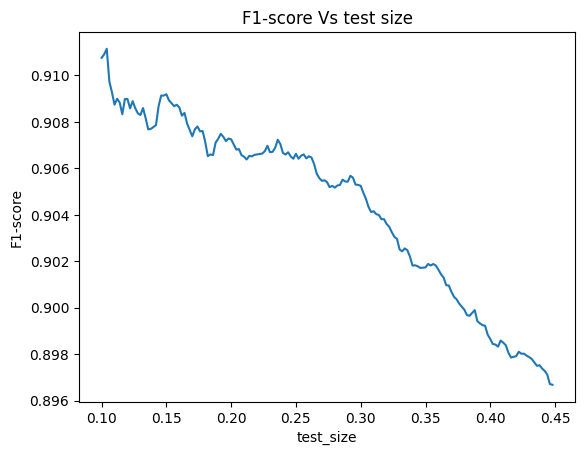

In [ ]:
# plot f1-score Vs N
plt.plot(test_sizes,f1score_test)
plt.title("F1-score Vs test size")
plt.xlabel("test_size")
plt.ylabel("F1-score")
plt.show()

overfitting

In [ ]:
np.where(f1score_test==max(f1score_test))[0][0]

2

In [ ]:
test_sizes[2]

0.10400000000000005

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.104, random_state=1, stratify=y)
knn_model = train_knn(X_train, y_train,n_neighbors=3)
y_hat = test_knn(knn_model,X_test, y_test)

Training time is 0.011306524276733398 seconds
Testing time is 7.649306774139404 seconds


In [ ]:
# F1-score and accuracy for 1st model
f1_score_method1 = f1_score(y_test,y_hat, average='micro')
accuracy_method1 = accuracy_score(y_test,y_hat)
print('F1-score is ',f1_score_method1)
print('Accuracy is ',accuracy_method1)

F1-score is  0.9111398485128395
Accuracy is  0.9111398485128395


## PCA

In [ ]:
pca = PCA()
pca.fit(X)

PCA()

In [ ]:
pca.explained_variance_

array([1.40603441e+01, 7.40791804e+00, 4.84876093e+00, 3.67611568e+00,
       3.55456980e+00, 2.39801607e+00, 2.17624347e+00, 2.00814559e+00,
       1.79338746e+00, 1.76018428e+00, 1.70179674e+00, 1.63748689e+00,
       1.53717247e+00, 1.39734640e+00, 1.37571670e+00, 1.29641445e+00,
       1.23677078e+00, 1.16362090e+00, 1.11822453e+00, 1.09123550e+00,
       1.05835158e+00, 1.04006559e+00, 9.97626272e-01, 9.81603887e-01,
       9.72011091e-01, 9.17517097e-01, 9.03748131e-01, 8.04340377e-01,
       7.78549494e-01, 7.54664077e-01, 7.27245759e-01, 6.44524730e-01,
       6.09996098e-01, 6.01264989e-01, 5.58004650e-01, 5.54013532e-01,
       5.38073607e-01, 5.27035091e-01, 4.86427849e-01, 4.57042984e-01,
       4.39260709e-01, 4.19983131e-01, 4.10844469e-01, 3.93133845e-01,
       3.55904413e-01, 3.44755709e-01, 3.35815390e-01, 3.15409594e-01,
       2.74264996e-01, 2.70896026e-01, 2.59473704e-01, 2.46702331e-01,
       2.42697258e-01, 2.04188001e-01, 1.59375101e-01, 1.55136863e-01,
      

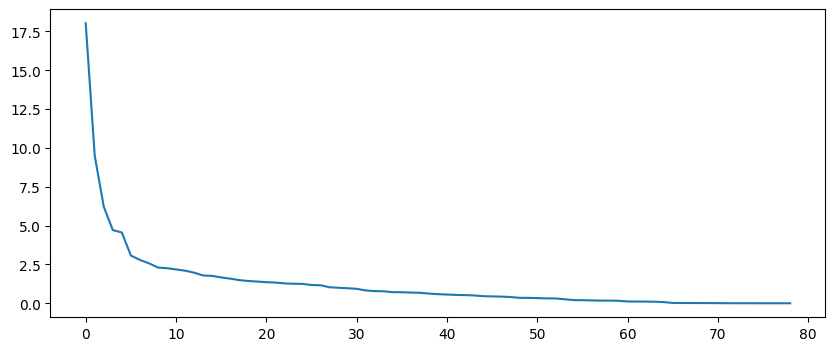

In [ ]:
# Scree plot
from matplotlib.pyplot import figure
figure(figsize=(10, 4))
percentage_info_captured = pca.explained_variance_*100/np.sum(pca.explained_variance_)
x = range(0,79)
plt.plot(x,percentage_info_captured)

In [ ]:
percentage_info_captured[:30]

array([18.01228542,  9.53405667,  6.23524057,  4.69708388,  4.53159454,
        3.06439085,  2.78472944,  2.58180836,  2.29972949,  2.24582861,
        2.19248621,  2.09039414,  1.96895646,  1.7956204 ,  1.75227719,
        1.66057639,  1.58932482,  1.49082404,  1.43674589,  1.40466119,
        1.35932369,  1.31960027,  1.28176742,  1.25824419,  1.2470506 ,
        1.18647537,  1.16213529,  1.03613078,  0.99908608,  0.96995278])

In [ ]:
np.sum(percentage_info_captured[:12])

60.28527855088123

In [ ]:
# consider first k principal components
f1score = []
accuracy = []
for i in range(12,62,2):
  pca = PCA(n_components=i)
  pca.fit(X)
  X_reduced = pca.transform(X)
  X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced  = train_test_split(X_reduced, y, test_size=0.104, random_state=1, stratify=y)
  knn_model_reduced = train_knn(X_train_reduced, y_train_reduced,n_neighbors=3)
  y_hat_reduced = test_knn(knn_model_reduced,X_test_reduced, y_test_reduced)
  f1score.append(f1_score(y_test_reduced,y_hat_reduced, average='micro'))
  accuracy.append(accuracy_score(y_test_reduced,y_hat_reduced))

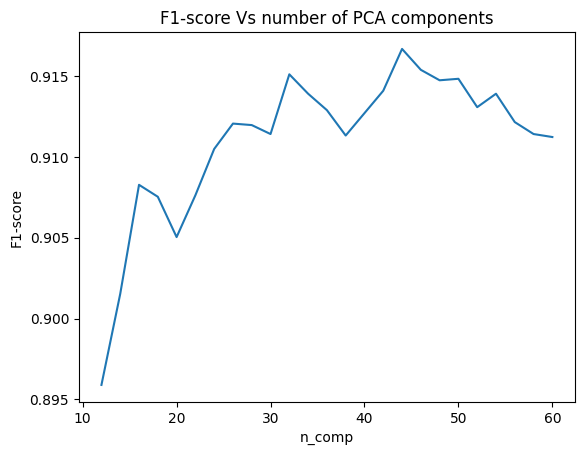

In [ ]:
n_comp = [i for i in range(12,62,2)]
plt.plot(n_comp ,f1score,label='train')
# plt.plot(n_comp ,f1score_test,label='test')
# plt.legend()
plt.title("F1-score Vs number of PCA components")
plt.xlabel("n_comp")
plt.ylabel("F1-score")
plt.show()

In [ ]:
12+2*np.where(f1score==max(f1score))[0][0]

44

In [ ]:
np.sum(percentage_info_captured[:44])

95.5317231415686

In [ ]:
# perform PCA for optimal number of components- 44
pca = PCA(n_components=44)
pca.fit(X)
# transform the data to be represented in the basis of the principal components
X_reduced = pca.transform(X)

In [ ]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced  = train_test_split(X_reduced, y, test_size=0.104, random_state=1, stratify=y)

In [ ]:
knn_model_reduced = train_knn(X_train_reduced, y_train_reduced,n_neighbors=3)
y_hat_reduced = test_knn(knn_model_reduced,X_test_reduced, y_test_reduced)

Training time is 0.017216920852661133 seconds
Testing time is 11.332757711410522 seconds


In [ ]:
# F1-score and accuracy for 2nd model
f1_score_method2 = f1_score(y_test_reduced,y_hat_reduced, average='micro')
accuracy_method2 = accuracy_score(y_test_reduced,y_hat_reduced)
print('F1-score is ',f1_score_method2)
print('Accuracy is ',accuracy_method2)

F1-score is  0.9179752447810826
Accuracy is  0.9179752447810826


In [ ]:
(f1_score_method2-f1_score_method1)*100/f1_score_method1


## Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
X_kpca = np.concatenate([X[:5200],X[-5200:]],axis=0)
y_kpca = np.concatenate([y[:5200],y[-5200:]],axis=0)

In [ ]:
X_kpca.shape

(10400, 79)

In [ ]:
y_kpca[5200:]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# select components (from pca) and kernel, try other kernels as well
start_time = time.time()
transformer = KernelPCA(n_components=79, kernel='poly')
X_transformed = transformer.fit_transform(X_kpca)
X_transformed.shape
end_time = time.time()
print('Time required is ', end_time-start_time)

Time required is  176.98220086097717


In [ ]:
transformer.eigenvalues_

array([10961.98268362,  6859.78774909,  3379.56489449,  2239.71634603,
        1910.1758824 ,  1733.23450136,  1671.80673047,  1537.43568364,
        1474.86607319,  1359.0379675 ,  1190.0061241 ,  1116.25931667,
        1075.10025178,  1061.0853304 ,   963.350568  ,   936.22217264,
         871.46848216,   824.94590319,   776.86800789,   763.65937381,
         730.07082966,   715.79292185,   698.29810628,   680.29790589,
         666.70581998,   626.38335875,   599.19236168,   573.00604777,
         555.55961461,   519.20837257,   509.49817546,   486.90350968,
         482.19575398,   453.26911743,   435.78153775,   421.57385955,
         402.06467357,   388.60387697,   375.52100086,   364.11290313,
         358.26249883,   346.49320832,   332.05568902,   330.24347229])

In [ ]:
X_transformed.shape

(10400, 79)

In [ ]:
# consider first k principal components
start_time = time.time()
from collections import defaultdict
f1score_transformed = defaultdict(list)
accuracy_transformed = defaultdict(list)
n_components = [i for i in range(60,110,10)]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in n_components:
  for j in kernels:
    transformer = KernelPCA(n_components=i,kernel=j)
    X_transformed = transformer.fit_transform(X_kpca)
    X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed  = train_test_split(X_transformed, y_kpca, test_size=0.104, random_state=1, stratify=y_kpca)
    knn_model_transformed = train_knn(X_train_transformed, y_train_transformed,n_neighbors=3)
    y_hat_transformed = test_knn(knn_model_transformed,X_test_transformed, y_test_transformed)
    f1score_transformed[j].append(f1_score(y_test_transformed,y_hat_transformed, average='micro'))
    accuracy_transformed[j].append(accuracy_score(y_test_transformed,y_hat_transformed))
end_time = time.time()

In [ ]:
print('Time required is ', end_time-start_time)

Time required is  3158.378203868866


In [ ]:
f1score_transformed

defaultdict(list,
            {'linear': [0.8401109057301294,
              0.8438077634011091,
              0.8438077634011091,
              0.8438077634011091,
              0.8438077634011091],
             'poly': [0.8234750462107209,
              0.8354898336414047,
              0.8419593345656192,
              0.8410351201478743,
              0.8410351201478743],
             'rbf': [0.8539741219963033,
              0.8521256931608133,
              0.8521256931608133,
              0.8502772643253235,
              0.8512014787430683],
             'sigmoid': [0.8364140480591498,
              0.8317929759704251,
              0.8317929759704251,
              0.8317929759704251,
              0.8299445471349353]})

In [ ]:
accuracy_transformed

defaultdict(list,
            {'linear': [0.8401109057301294,
              0.8438077634011091,
              0.8438077634011091,
              0.8438077634011091,
              0.8438077634011091],
             'poly': [0.8234750462107209,
              0.8354898336414048,
              0.8419593345656192,
              0.8410351201478743,
              0.8410351201478743],
             'rbf': [0.8539741219963032,
              0.8521256931608133,
              0.8521256931608133,
              0.8502772643253235,
              0.8512014787430684],
             'sigmoid': [0.8364140480591498,
              0.8317929759704251,
              0.8317929759704251,
              0.8317929759704251,
              0.8299445471349353]})

RBF kernel with 60 components gives the best performance metrics with the given computational resources and dataset size

In [ ]:
# tune the hyperparameter gamma
gamma = [0.01,0.05,0.1,0.5,1,2,5,10]
len(gamma)

8

In [ ]:
gamma = [0.01,0.05,0.1,0.5,1,2,5,10]
start_time = time.time()

f1score_transformed_rbf = []
accuracy_transformed_rbf = []
for g in gamma:
  transformer = KernelPCA(n_components=60,kernel='rbf',gamma=g)
  X_transformed = transformer.fit_transform(X_kpca)
  X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed  = train_test_split(X_transformed, y_kpca, test_size=0.104, random_state=1, stratify=y_kpca)
  knn_model_transformed = train_knn(X_train_transformed, y_train_transformed,n_neighbors=3)
  y_hat_transformed = test_knn(knn_model_transformed,X_test_transformed, y_test_transformed)
  f1score_transformed_rbf.append(f1_score(y_test_transformed,y_hat_transformed, average='micro'))
  accuracy_transformed_rbf.append(accuracy_score(y_test_transformed,y_hat_transformed))
end_time = time.time()



Training time is 0.002332448959350586 seconds
Testing time is 0.1734752655029297 seconds
Training time is 0.0022957324981689453 seconds
Testing time is 0.1420581340789795 seconds
Training time is 0.002203702926635742 seconds
Testing time is 0.17864775657653809 seconds
Training time is 0.00222015380859375 seconds
Testing time is 0.1748485565185547 seconds
Training time is 0.002247333526611328 seconds
Testing time is 0.1667802333831787 seconds
Training time is 0.005215644836425781 seconds
Testing time is 0.3051304817199707 seconds
Training time is 0.0023009777069091797 seconds
Testing time is 0.1658313274383545 seconds
Training time is 0.002279043197631836 seconds
Testing time is 0.17759323120117188 seconds


In [ ]:
f1score_transformed_rbf

[0.8502772643253235,
 0.8151571164510166,
 0.8133086876155268,
 0.7218114602587801,
 0.7412199630314233,
 0.6913123844731978,
 0.6617375231053605,
 0.5720887245841035]

In [ ]:
accuracy_transformed_rbf

[0.8502772643253235,
 0.8151571164510166,
 0.8133086876155268,
 0.7218114602587801,
 0.7412199630314233,
 0.6913123844731978,
 0.6617375231053605,
 0.5720887245841035]

In [ ]:
print('Time required is ', end_time-start_time)

Time required is  1347.465002298355


In [ ]:
transformer = KernelPCA(n_components=60,kernel='rbf',gamma=0.01)
X_transformed = transformer.fit_transform(X_kpca)

In [ ]:
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed  = train_test_split(X_transformed, y_kpca, test_size=0.104, random_state=1, stratify=y_kpca)

In [ ]:
knn_model_transformed = train_knn(X_train_transformed, y_train_transformed,n_neighbors=3)
y_hat_transformed = test_knn(knn_model_transformed,X_test_transformed, y_test_transformed)

Training time is 0.004533290863037109 seconds
Testing time is 0.10914182662963867 seconds


In [ ]:
# F1-score and accuracy for 2nd model
f1_score_method3 = f1_score(y_test_transformed,y_hat_transformed, average='micro')
accuracy_method3 = accuracy_score(y_test_transformed,y_hat_transformed)
print('F1-score is ',f1_score_method3)
print('Accuracy is ',accuracy_method3)

F1-score is  0.8502772643253235
Accuracy is  0.8502772643253235


## Autoencoder

In [ ]:
tf.random.set_seed(1)

In [ ]:
start_time = time.time()
n = [i for i in range(30,80,5)]
f1score_encoded = defaultdict(list)
accuracy_encoded = defaultdict(list)
activations = ['relu','sigmoid','softmax','tanh','exponential']
for i in n:
  for j in activations:
    n_components = i
    input_data = keras.Input(shape=(79,))
    encoded = layers.Dense(n_components, activation=j)(input_data)
    # decoded = layers.Dense(79, activation=j)(encoded)
    encoder = keras.Model(input_data, encoded)
    encoded_data= encoder.predict(X)
    X_train, X_test, y_train, y_test  = train_test_split(encoded_data, y, test_size=0.104, random_state=1, stratify=y)
    knn_model_encoded = train_knn(X_train, y_train,n_neighbors=3)
    y_hat_encoded = test_knn(knn_model_encoded,X_test, y_test)
    f1score_encoded[j].append(f1_score(y_test,y_hat_encoded, average='micro'))
    accuracy_encoded[j].append(accuracy_score(y_test,y_hat_encoded))

end_time = time.time()

3253/3253 [==============================] - 4s 1ms/step
Training time is 0.007202625274658203 seconds
Testing time is 5.349573135375977 seconds
3253/3253 [==============================] - 5s 1ms/step
Training time is 0.01016092300415039 seconds
Testing time is 9.852611064910889 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.007139921188354492 seconds
Testing time is 7.312535524368286 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.007489442825317383 seconds
Testing time is 6.284998893737793 seconds
3253/3253 [==============================] - 6s 2ms/step
Training time is 0.007044076919555664 seconds
Testing time is 5.183207273483276 seconds
3253/3253 [==============================] - 5s 2ms/step
Training time is 0.0073511600494384766 seconds
Testing time is 5.4832563400268555 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.007297039031982422 seconds
Testing time is 5.51139235

In [ ]:
f1score_encoded

defaultdict(list,
            {'relu': [0.8704969517827452,
              0.880011084426381,
              0.8827821910216146,
              0.8960835026787364,
              0.8877701828930353,
              0.8954369111398485,
              0.8943284685017551,
              0.8902641788287456,
              0.906336597081101,
              0.9000554221319047],
             'sigmoid': [0.8898946979493811,
              0.8953445409200074,
              0.8996859412525402,
              0.9007943838906337,
              0.907814520598559,
              0.9030112691668206,
              0.9036578607057085,
              0.9031960096065028,
              0.9007020136707925,
              0.9020875669684094],
             'softmax': [0.8568261592462592,
              0.8713282837613153,
              0.8694808793644929,
              0.8717901348605209,
              0.8737299094771845,
              0.8783484204692407,
              0.8872159615739885,
              0.8811195270644744,
 

In [ ]:
accuracy_encoded

defaultdict(list,
            {'relu': [0.8704969517827452,
              0.880011084426381,
              0.8827821910216146,
              0.8960835026787364,
              0.8877701828930353,
              0.8954369111398485,
              0.8943284685017551,
              0.8902641788287456,
              0.906336597081101,
              0.9000554221319047],
             'sigmoid': [0.8898946979493811,
              0.8953445409200074,
              0.8996859412525402,
              0.9007943838906337,
              0.907814520598559,
              0.9030112691668206,
              0.9036578607057085,
              0.9031960096065028,
              0.9007020136707925,
              0.9020875669684094],
             'softmax': [0.856826159246259,
              0.8713282837613153,
              0.8694808793644929,
              0.8717901348605209,
              0.8737299094771845,
              0.8783484204692407,
              0.8872159615739885,
              0.8811195270644744,
  

In [ ]:
print('Time required is ', end_time-start_time)

Time required is  733.9884729385376


In [ ]:
start_time = time.time()
f1score_encoded_tanh = []
accuracy_encoded_tanh = []
n = [i for i in range(65,80,2)]
for i in range(65,80,2):
    n_components = i
    input_data = keras.Input(shape=(79,))
    encoded = layers.Dense(n_components, activation='tanh')(input_data)
    # decoded = layers.Dense(79, activation=j)(encoded)
    encoder = keras.Model(input_data, encoded)
    encoded_data= encoder.predict(X)
    X_train, X_test, y_train, y_test  = train_test_split(encoded_data, y, test_size=0.104, random_state=1, stratify=y)
    knn_model_encoded = train_knn(X_train, y_train,n_neighbors=3)
    y_hat_encoded = test_knn(knn_model_encoded,X_test, y_test)
    f1score_encoded_tanh.append(f1_score(y_test,y_hat_encoded, average='micro'))
    accuracy_encoded_tanh.append(accuracy_score(y_test,y_hat_encoded))
end_time = time.time()

3253/3253 [==============================] - 4s 1ms/step
Training time is 0.012819051742553711 seconds
Testing time is 9.046572923660278 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.009400367736816406 seconds
Testing time is 9.28536605834961 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.008493185043334961 seconds
Testing time is 9.264983892440796 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.010860204696655273 seconds
Testing time is 9.383204460144043 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.010020732879638672 seconds
Testing time is 9.481116771697998 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.008614301681518555 seconds
Testing time is 9.625948905944824 seconds
3253/3253 [==============================] - 4s 1ms/step
Training time is 0.008887290954589844 seconds
Testing time is 9.6468839645

In [ ]:
f1score_encoded_tanh

[0.8983003879549233,
 0.9057823757620543,
 0.9080916312580823,
 0.9066137077406244,
 0.9075374099390358,
 0.9062442268612599,
 0.9036578607057085,
 0.9052281544430075]

In [ ]:
accuracy_encoded_tanh

[0.8983003879549233,
 0.9057823757620543,
 0.9080916312580823,
 0.9066137077406244,
 0.9075374099390356,
 0.9062442268612599,
 0.9036578607057085,
 0.9052281544430075]

In [ ]:
print('Time required is ', end_time-start_time)

Time required is  116.7986888885498


In [ ]:
n_components = 69
input_data = keras.Input(shape=(79,))
encoded = layers.Dense(n_components, activation='tanh')(input_data)
encoder = keras.Model(input_data, encoded)
encoded_data= encoder.predict(X)
X_train, X_test, y_train, y_test  = train_test_split(encoded_data, y, test_size=0.104, random_state=1, stratify=y)
knn_model_encoded = train_knn(X_train, y_train,n_neighbors=3)
y_hat_encoded = test_knn(knn_model_encoded,X_test, y_test)

3253/3253 [==============================] - 6s 2ms/step
Training time is 0.008900642395019531 seconds
Testing time is 9.288630962371826 seconds


In [ ]:
f1_score_method5 = f1_score(y_test,y_hat_encoded, average='micro')
accuracy_method5 = accuracy_score(y_test,y_hat_encoded)
print('F1-score is ',f1_score_method5)
print('Accuracy is ',accuracy_method5)

F1-score is  0.9067060779604655
Accuracy is  0.9067060779604655
